In [1]:
import pandas as pd
from sodapy import Socrata


client = Socrata("data.cdc.gov",None)
results = client.get("r8kw-7aab",limit=4000)
results_df = pd.DataFrame.from_records(results)
results_df.head()

,data_as_of,start_week,end_week,group,state,indicator,covid_deaths,total_deaths,percent_of_expected_deaths,pneumonia_deaths,pneumonia_and_covid_deaths,influenza_deaths,pneumonia_influenza_or_covid_19_deaths,footnote
0,2020-05-29T00:00:00.000,2020-02-01T00:00:00.000,2020-02-01T00:00:00.000,By week,United States,Week-ending,0,57632,0.97,3721,0,475,4196,NaN
1,2020-05-29T00:00:00.000,2020-02-08T00:00:00.000,2020-02-08T00:00:00.000,By week,United States,Week-ending,1,58283,0.98,3716,0,511,4228,NaN
2,2020-05-29T00:00:00.000,2020-02-15T00:00:00.000,2020-02-15T00:00:00.000,By week,United States,Week-ending,0,57623,0.98,3750,0,543,4293,NaN
3,2020-05-29T00:00:00.000,2020-02-22T00:00:00.000,2020-02-22T00:00:00.000,By week,United States,Week-ending,2,57699,0.99,3619,0,554,4175,NaN
4,2020-05-29T00:00:00.000,2020-02-29T00:00:00.000,2020-02-29T00:00:00.000,By week,United States,Week-ending,5,58038,1.01,3740,3,631,4373,NaN


In [2]:
# results_df.columns

In [3]:
float_cols=['total_deaths', 'percent_of_expected_deaths', 'pneumonia_deaths','pneumonia_and_covid_deaths', 'influenza_deaths', 'pneumonia_influenza_or_covid_19_deaths']
date_cols=['data_as_of','start_week','end_week']
def transform_df(df,date_cols,float_cols):
    for col in date_cols:
        df[col] = pd.to_datetime(df[col])
    for col in float_cols:
        df[col] = df[col].astype(float)
    return df.drop_duplicates(subset=['start_week','state','indicator'],keep='last').reset_index(drop=True)

results_df = pd.DataFrame.from_records(results).pipe(transform_df,date_cols,float_cols)

results_df.head()

,data_as_of,start_week,end_week,group,state,indicator,covid_deaths,total_deaths,percent_of_expected_deaths,pneumonia_deaths,pneumonia_and_covid_deaths,influenza_deaths,pneumonia_influenza_or_covid_19_deaths,footnote
0,2020-05-29,2020-02-01,2020-02-01,By week,United States,Week-ending,0,57632.0,0.97,3721.0,0.0,475.0,4196.0,NaN
1,2020-05-29,2020-02-08,2020-02-08,By week,United States,Week-ending,1,58283.0,0.98,3716.0,0.0,511.0,4228.0,NaN
2,2020-05-29,2020-02-15,2020-02-15,By week,United States,Week-ending,0,57623.0,0.98,3750.0,0.0,543.0,4293.0,NaN
3,2020-05-29,2020-02-22,2020-02-22,By week,United States,Week-ending,2,57699.0,0.99,3619.0,0.0,554.0,4175.0,NaN
4,2020-05-29,2020-02-29,2020-02-29,By week,United States,Week-ending,5,58038.0,1.01,3740.0,3.0,631.0,4373.0,NaN


In [4]:
results_df.start_week.unique()

array(['2020-02-01T00:00:00.000000000', '2020-02-08T00:00:00.000000000',
       '2020-02-15T00:00:00.000000000', '2020-02-22T00:00:00.000000000',
       '2020-02-29T00:00:00.000000000', '2020-03-07T00:00:00.000000000',
       '2020-03-14T00:00:00.000000000', '2020-03-21T00:00:00.000000000',
       '2020-03-28T00:00:00.000000000', '2020-04-04T00:00:00.000000000',
       '2020-04-11T00:00:00.000000000', '2020-04-18T00:00:00.000000000',
       '2020-04-25T00:00:00.000000000', '2020-05-02T00:00:00.000000000',
       '2020-05-09T00:00:00.000000000', '2020-05-16T00:00:00.000000000',
       '2020-05-23T00:00:00.000000000'], dtype='datetime64[ns]')

In [5]:
results_df['state'].unique()

array(['United States', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'New York City', 'North Carolina', 'North Dakota', 'Ohio',
       'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin',
       'Wyoming', 'Puerto Rico'], dtype=object)

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x6aa07b10>)

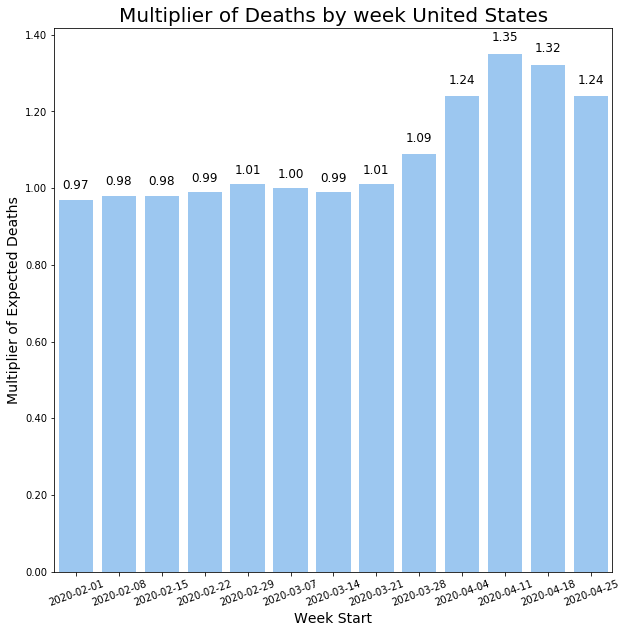

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
%matplotlib inline

def autolabel(rects, ax, loc = 1.02, perc = True, ha = 'center'):
    # attach some text labels

    for rect in rects:
        height = rect.get_height()
        if perc:
            bar_label = '%1.1f' % float(height*100) + "%"
        else:
            bar_label = '%1.2f' % float(height)
        ax.text(rect.get_x() + rect.get_width()/2., loc*height,
                bar_label,
                ha=ha, va='bottom', fontsize = 12)

def plot_death_bar(df,state='United States',with_multiplier='percent'):
    data = df[df['state']==state]
    fig,ax = plt.subplots(figsize=(10,10))
    if with_multiplier=='percent':
        formatter = FuncFormatter(lambda y, pos:"%d%%" % (y*100))
    else:
        formatter = FuncFormatter(lambda y, pos:"%.2f" % (y))
#     data['percent_of_expected_deaths']-=1
    sns.barplot(x='start_week',y='percent_of_expected_deaths',data=data,color='dodgerblue',alpha=.5)
#     ax.set_xticks(data['start_week'])
    percent = (with_multiplier=='percent')
    autolabel(ax.patches,ax,perc=percent)
    ax.xaxis.set_tick_params(rotation=20)
    ax.yaxis.set_major_formatter(formatter)
    ax.set_xticklabels(data['start_week'].dt.strftime('%Y-%m-%d'))
    if with_multiplier=='percent':
        ax.set_title('Percent of Deaths by week {}'.format(state),fontsize=20)
        ax.set_ylabel('Percent of Expected Deaths',fontsize=14)
    else:
        ax.set_title('Multiplier of Deaths by week {}'.format(state),fontsize=20)
        ax.set_ylabel('Multiplier of Expected Deaths',fontsize=14)
    ax.set_xlabel("Week Start",fontsize=14)
    return fig,ax

def plot_death_line(df,state_list=[]):
    state_list = ['United States']+state_list
    data = df[df['state'].isin(state_list)]
    fig,ax = plt.subplots(figsize=(10,10))
    formatter = FuncFormatter(lambda y, pos:"%d%%" % (y*100))
    sns.lineplot(x='start_week',y='percent_of_expected_deaths',data=data,hue='state')
#     ax.set_xticks(data['start_week'])
#     autolabel(ax.patches,ax)
    ax.xaxis.set_tick_params(rotation=20)
    ax.yaxis.set_major_formatter(formatter)
    ax.set_xticks(data['start_week'].drop_duplicates())
#     ax.set_xticklabels(data['start_week'].drop_duplicates().dt.strftime('%Y-%m-%d').iloc[::2])
#     ax.set_xticklabels(data['start_week'].dt.strftime('%Y-%m-%d'))
    ax.set_title('Percent of Deaths by week US',fontsize=20)
    ax.set_ylabel('Percent of Expected Deaths',fontsize=14)
    ax.set_xlabel("Week Start",fontsize=14)
    return fig,ax

plot_death_bar(results_df[results_df['start_week']<'2020-05-01'],with_multiplier='blue')

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x6cc5e670>)

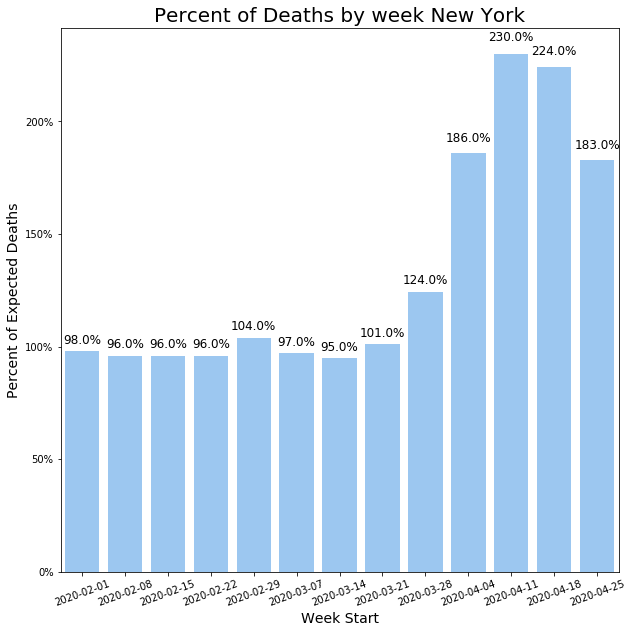

In [7]:
plot_death_bar(results_df[results_df['start_week']<'2020-05-01'],'New York')

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x6a7de090>)

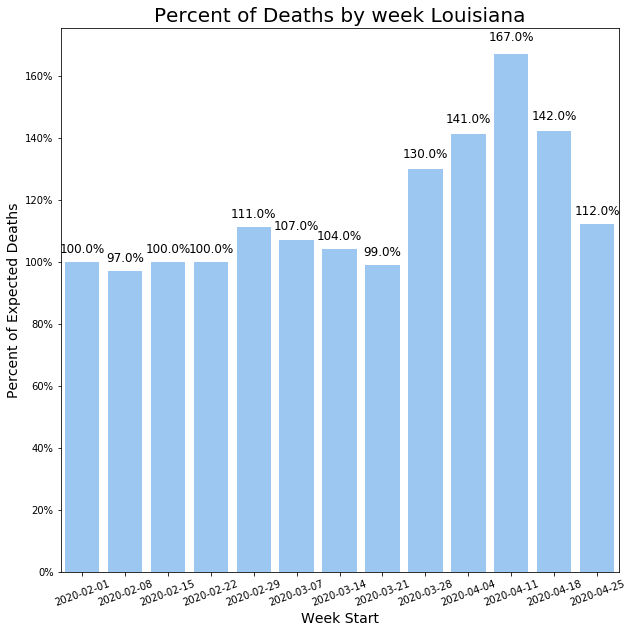

In [8]:
plot_death_bar(results_df[results_df['start_week']<'2020-05-01'],'Louisiana')

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x6a74ecb0>)

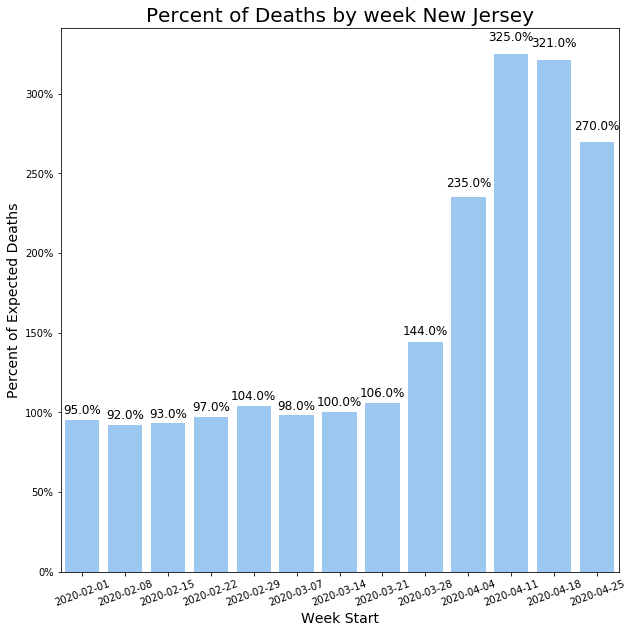

In [9]:
plot_death_bar(results_df[results_df['start_week']<'2020-05-01'],'New Jersey')

/home/pi/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x6a740c30>)

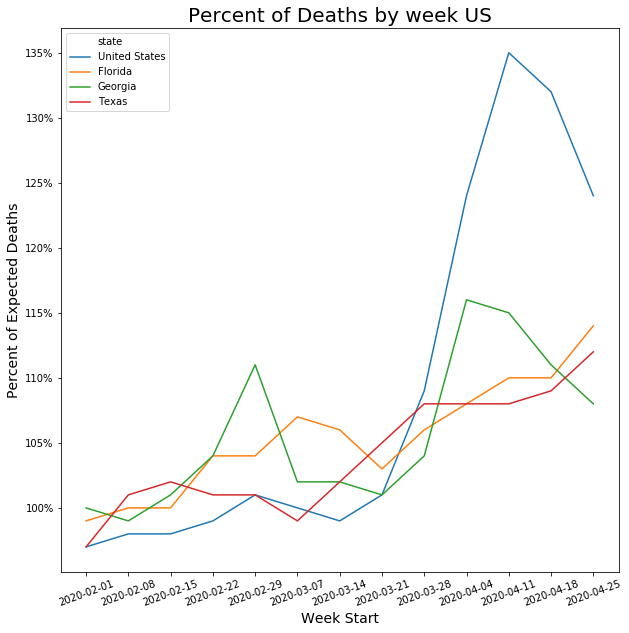

In [10]:
plot_death_line(results_df[results_df['start_week']<'2020-05-01'],['Florida','Georgia','Texas'])

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x6a478690>)

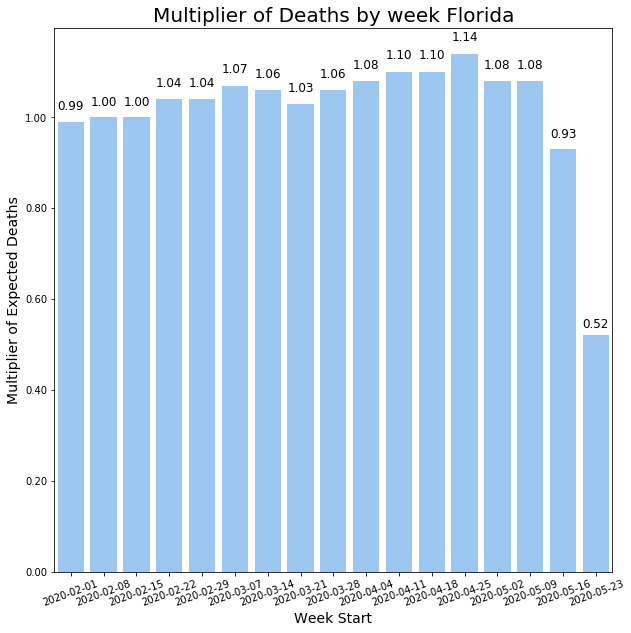

In [11]:
plot_death_bar(results_df,'Florida',with_multiplier='yes')

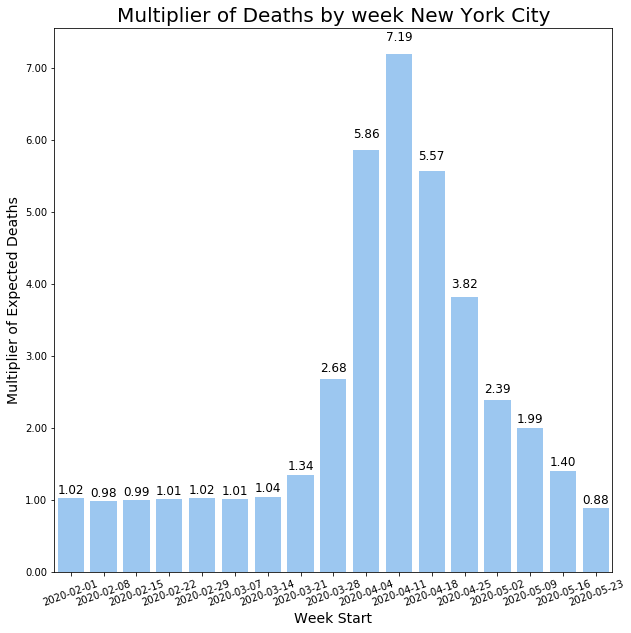

In [12]:
fig,ax = plot_death_bar(results_df,'New York City',with_multiplier='yes')
fig.savefig("weekly_deaths_nyc_multiplier2.png")

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x6838f9d0>)

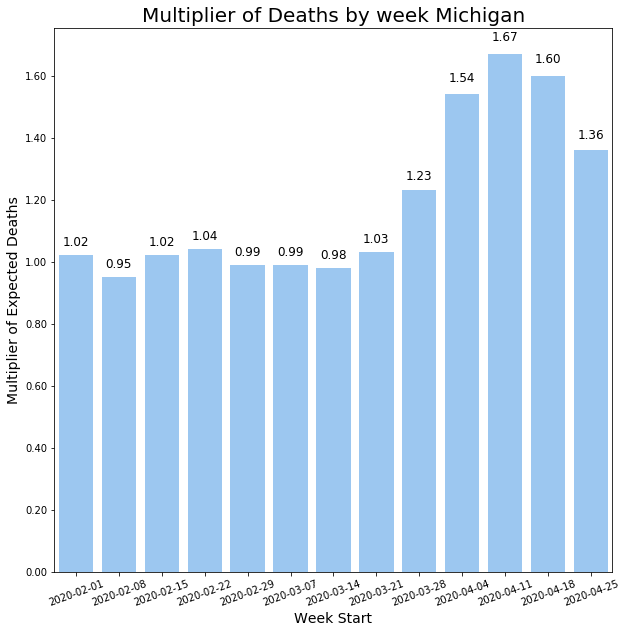

In [13]:
plot_death_bar(results_df[results_df['start_week']<'2020-05-01'],'Michigan',with_multiplier='yes')

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x683611b0>)

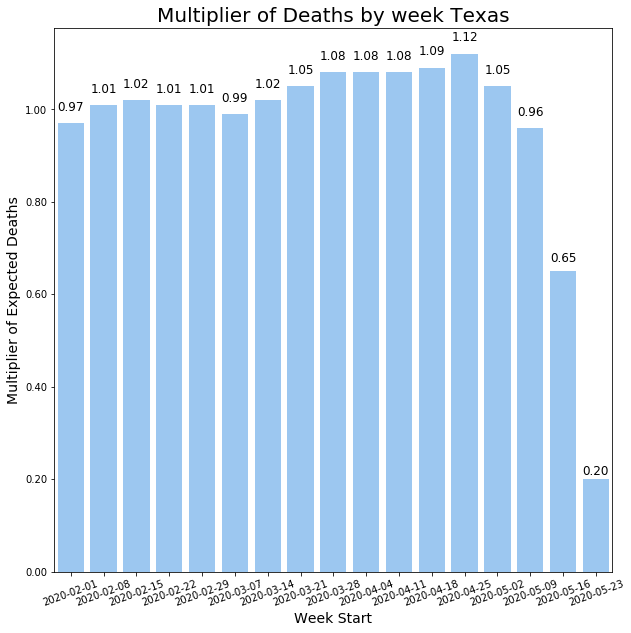

In [14]:
plot_death_bar(results_df,'Texas',with_multiplier='yes')

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x682e7630>)

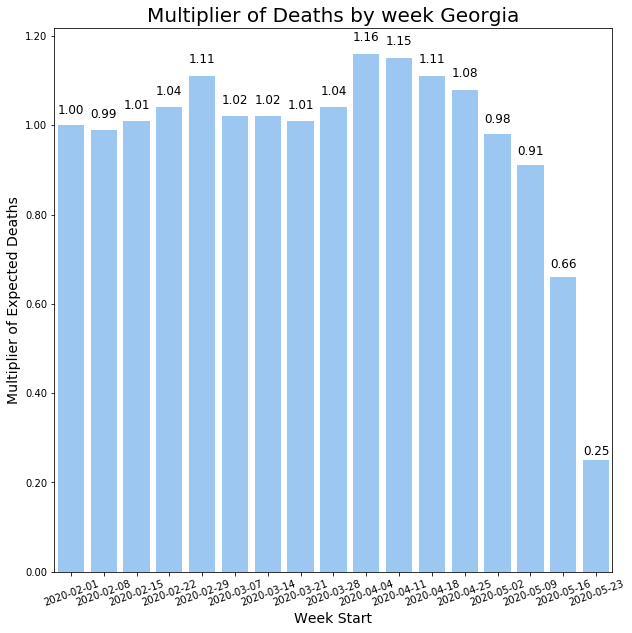

In [15]:
plot_death_bar(results_df,'Georgia',with_multiplier='yes')

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x682d3730>)

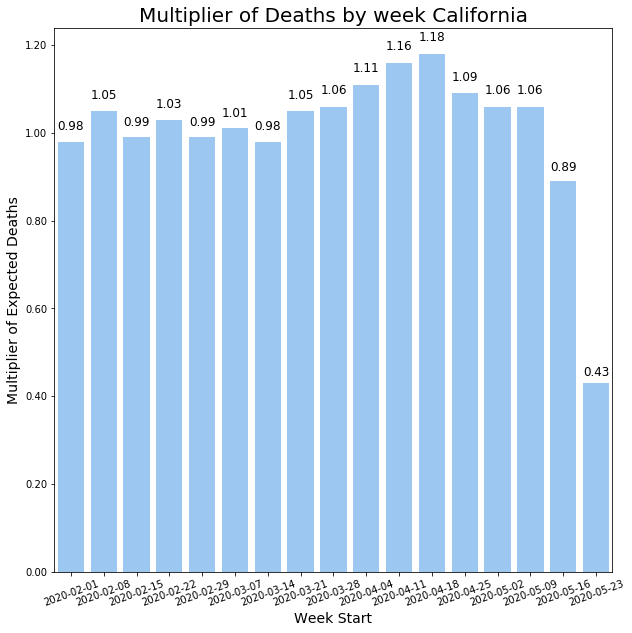

In [16]:
plot_death_bar(results_df,'California',with_multiplier='yes')

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x68079f30>)

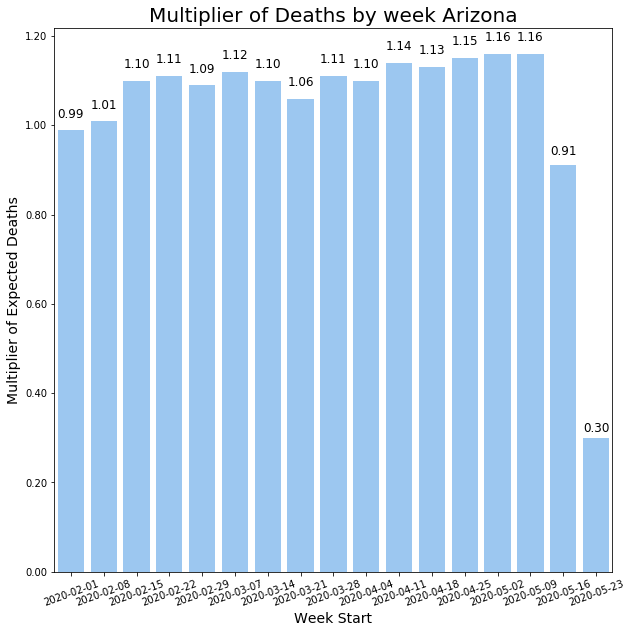

In [17]:
plot_death_bar(results_df,'Arizona',with_multiplier='yes')

In [18]:
results_df.columns

Index(['data_as_of', 'start_week', 'end_week', 'group', 'state', 'indicator',
       'covid_deaths', 'total_deaths', 'percent_of_expected_deaths',
       'pneumonia_deaths', 'pneumonia_and_covid_deaths', 'influenza_deaths',
       'pneumonia_influenza_or_covid_19_deaths', 'footnote'],
      dtype='object')

In [19]:
results_df[results_df['state']=='Georgia'][['start_week','covid_deaths','total_deaths','percent_of_expected_deaths','pneumonia_deaths','influenza_deaths']]

,start_week,covid_deaths,total_deaths,percent_of_expected_deaths,pneumonia_deaths,influenza_deaths
187,2020-02-01,0,1775.0,1.00,87.0,NaN
188,2020-02-08,0,1741.0,0.99,93.0,11.0
189,2020-02-15,0,1732.0,1.01,88.0,16.0
190,2020-02-22,0,1706.0,1.04,80.0,21.0
191,2020-02-29,0,1808.0,1.11,87.0,NaN
192,2020-03-07,NaN,1716.0,1.02,83.0,NaN
193,2020-03-14,NaN,1727.0,1.02,101.0,NaN
194,2020-03-21,34,1703.0,1.01,128.0,NaN
195,2020-03-28,88,1785.0,1.04,149.0,NaN
196,2020-04-04,188,1886.0,1.16,220.0,NaN


In [20]:
results_df.sort_values(by='percent_of_expected_deaths',ascending=False).head(20)

,data_as_of,start_week,end_week,group,state,indicator,covid_deaths,total_deaths,percent_of_expected_deaths,pneumonia_deaths,pneumonia_and_covid_deaths,influenza_deaths,pneumonia_influenza_or_covid_19_deaths,footnote
588,2020-05-29,2020-04-11,2020-04-11,By week,New York City,Week-ending,4669,7660.0,7.19,2068.0,1775.0,325.0,4972.0,NaN
587,2020-05-29,2020-04-04,2020-04-04,By week,New York City,Week-ending,3066,6038.0,5.86,1706.0,1291.0,211.0,3490.0,NaN
589,2020-05-29,2020-04-18,2020-04-18,By week,New York City,Week-ending,3685,5661.0,5.57,1466.0,1331.0,172.0,3823.0,NaN
590,2020-05-29,2020-04-25,2020-04-25,By week,New York City,Week-ending,2357,3771.0,3.82,1042.0,944.0,78.0,2456.0,NaN
537,2020-05-29,2020-04-11,2020-04-11,By week,New Jersey,Week-ending,2253,4630.0,3.25,1368.0,1133.0,10.0,2491.0,NaN
538,2020-05-29,2020-04-18,2020-04-18,By week,New Jersey,Week-ending,2335,4545.0,3.21,1271.0,1083.0,NaN,2526.0,One or more data cells have counts between 1–9...
539,2020-05-29,2020-04-25,2020-04-25,By week,New Jersey,Week-ending,1781,3688.0,2.70,1074.0,891.0,NaN,1966.0,One or more data cells have counts between 1–9...
586,2020-05-29,2020-03-28,2020-03-28,By week,New York City,Week-ending,952,2763.0,2.68,596.0,357.0,46.0,1199.0,NaN
591,2020-05-29,2020-05-02,2020-05-02,By week,New York City,Week-ending,1305,2403.0,2.39,619.0,535.0,NaN,1391.0,One or more data cells have counts between 1–9...
536,2020-05-29,2020-04-04,2020-04-04,By week,New Jersey,Week-ending,1208,3443.0,2.35,862.0,618.0,10.0,1459.0,NaN


In [21]:
(results_df['start_week']<'2020-05-01').sum()

702

In [22]:
results_df[results_df['state'].isin(['United States'])]

,data_as_of,start_week,end_week,group,state,indicator,covid_deaths,total_deaths,percent_of_expected_deaths,pneumonia_deaths,pneumonia_and_covid_deaths,influenza_deaths,pneumonia_influenza_or_covid_19_deaths,footnote
0,2020-05-29,2020-02-01,2020-02-01,By week,United States,Week-ending,0,57632.0,0.97,3721.0,0.0,475.0,4196.0,NaN
1,2020-05-29,2020-02-08,2020-02-08,By week,United States,Week-ending,1,58283.0,0.98,3716.0,0.0,511.0,4228.0,NaN
2,2020-05-29,2020-02-15,2020-02-15,By week,United States,Week-ending,0,57623.0,0.98,3750.0,0.0,543.0,4293.0,NaN
3,2020-05-29,2020-02-22,2020-02-22,By week,United States,Week-ending,2,57699.0,0.99,3619.0,0.0,554.0,4175.0,NaN
4,2020-05-29,2020-02-29,2020-02-29,By week,United States,Week-ending,5,58038.0,1.01,3740.0,3.0,631.0,4373.0,NaN
5,2020-05-29,2020-03-07,2020-03-07,By week,United States,Week-ending,32,57850.0,1.00,3835.0,16.0,615.0,4465.0,NaN
6,2020-05-29,2020-03-14,2020-03-14,By week,United States,Week-ending,51,56646.0,0.99,3833.0,26.0,601.0,4458.0,NaN
7,2020-05-29,2020-03-21,2020-03-21,By week,United States,Week-ending,540,57120.0,1.01,4380.0,244.0,531.0,5201.0,NaN
8,2020-05-29,2020-03-28,2020-03-28,By week,United States,Week-ending,3000,60845.0,1.09,5939.0,1354.0,431.0,7967.0,NaN
9,2020-05-29,2020-04-04,2020-04-04,By week,United States,Week-ending,9362,69037.0,1.24,9440.0,4492.0,454.0,14541.0,NaN


In [23]:
results_df['data_as_of'].value_counts()

2020-05-29    918
Name: data_as_of, dtype: int64

In [24]:
results_df['expected_deaths'] = results_df['total_deaths']/results_df['percent_of_expected_deaths']

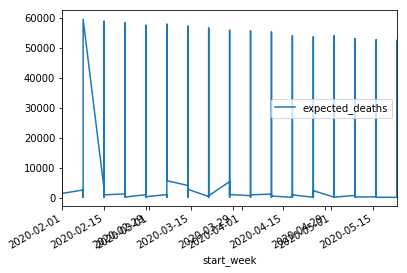

In [25]:
results_df.set_index('start_week')[['expected_deaths','covid_deaths']].plot()

In [26]:
results_df['deaths_over_expected'] = results_df['total_deaths']-results_df['expected_deaths']


In [27]:
final_us_df = pd.melt(results_df[results_df['state']=='United States'],id_vars=['start_week'],value_vars=['covid_deaths','deaths_over_expected'])

In [28]:
final_us_df['value'] = final_us_df['value'].astype(int)

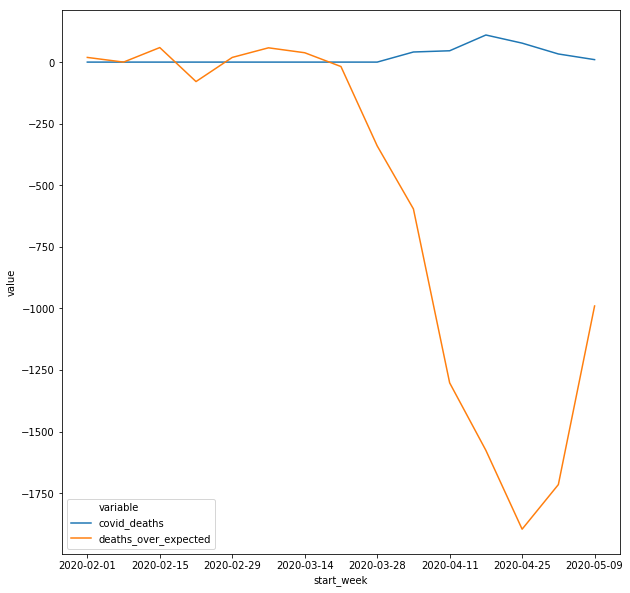

In [29]:
def plot_comp(state):
    final_us_df = pd.melt(results_df[results_df['state']==state].iloc[:-2],id_vars=['start_week'],value_vars=['covid_deaths','deaths_over_expected'])
    final_us_df['value'] = final_us_df['value'].fillna(0).astype(int)
    fig,ax = plt.subplots(figsize=(10,10))
    sns.lineplot(x='start_week',y='value',hue='variable',data=final_us_df,ax = ax)
    ax.set_xticks(final_us_df['start_week'].drop_duplicates()[::2])

plot_comp('North Carolina')

In [30]:
NY = results_df[results_df['state']=='New York City'].reset_index(drop=True)
NY['start_week'].dt.strftime('%Y-%m-%d')

0     2020-02-01
1     2020-02-08
2     2020-02-15
3     2020-02-22
4     2020-02-29
5     2020-03-07
6     2020-03-14
7     2020-03-21
8     2020-03-28
9     2020-04-04
10    2020-04-11
11    2020-04-18
12    2020-04-25
13    2020-05-02
14    2020-05-09
15    2020-05-16
16    2020-05-23
Name: start_week, dtype: object

/home/pi/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


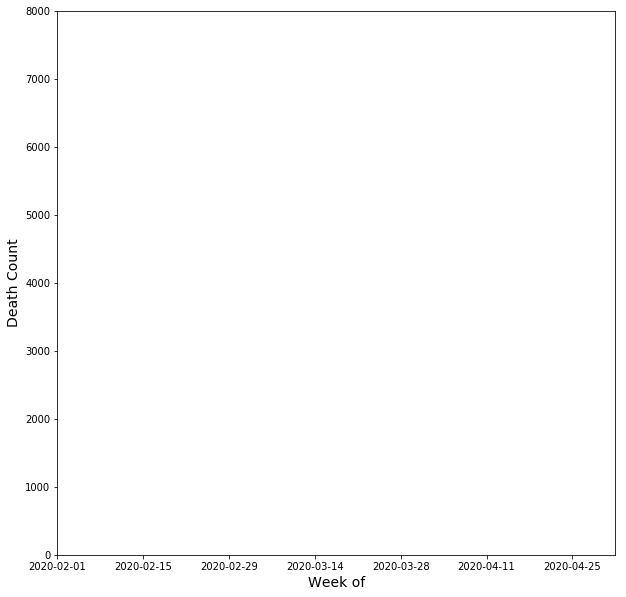

In [31]:
from celluloid import Camera
from IPython.display import HTML

fig,ax = plt.subplots(figsize=(10,10))
camera = Camera(fig)
for i in range(NY.shape[0]-3):
    NY.iloc[0:i+1]['total_deaths'].plot(ax=ax,color='dodgerblue')
    ax.set_xticklabels(NY['start_week'].dt.strftime('%Y-%m-%d').iloc[::2])
    ax.text(0.5,1.05,'Death Count in NYC: Week of {}: {:.0f}'.format(NY['start_week'].dt.strftime('%Y-%m-%d').iloc[i],NY['total_deaths'].iloc[i]),fontsize=20,horizontalalignment='center',transform = ax.transAxes)
    ax.set_ylabel('Death Count',fontsize=14)
    ax.set_xlabel("Week of",fontsize=14)
    ax.set_ylim(0,8000)
    ax.text(1,-.1,'Data Source: https://data.cdc.gov/NCHS/Provisional-COVID-19-Death-Counts-by-Week-Ending-D/r8kw-7aab',fontsize=10,horizontalalignment='right',fontstyle='italic', bbox=dict(facecolor='dodgerblue',alpha=0.5),transform = ax.transAxes)
    camera.snap()
    
animation = camera.animate(interval=1000)
animation.save('weekly_deaths_nyc.mp4')



In [32]:
import os
import subprocess


# subprocess.call('ffmpeg -i weekly_deaths_nyc.mp4 weekly_deaths_nyc.gif',cwd = os.getcwd(),shell=True)
out = subprocess.Popen(['ffmpeg','-y','-i','weekly_deaths_nyc.mp4','weekly_deaths_nyc.gif'],stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
stdout, stderr = out.communicate()
# os.system('ls')
# subprocess.call('echo "I like poratoes"',shell=True)
# stdout

<img src="weekly_deaths_nyc.gif" width="600">

/home/pi/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


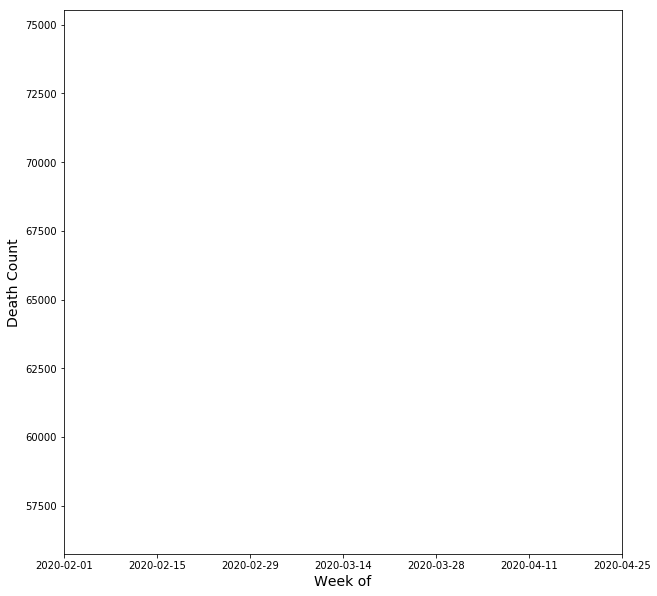

In [33]:
def make_death_gif(results_df,state,max_date='2020-05-01'):
    plot_data = results_df[results_df['state']==state].reset_index(drop=True)
    plot_data['start_week'].dt.strftime('%Y-%m-%d')
    plot_data = plot_data[plot_data['start_week']<max_date].reset_index(drop=True)
    fig,ax = plt.subplots(figsize=(10,10))
    camera = Camera(fig)
    for i in range(plot_data.shape[0]):
        plot_data.iloc[0:i+1]['total_deaths'].plot(ax=ax,color='dodgerblue')
        ax.set_xticklabels(plot_data['start_week'].dt.strftime('%Y-%m-%d').iloc[::2])
        ax.text(0.5,1.05,'Death Count in {}: Week of {}: {:.0f}'.format(state,plot_data['start_week'].dt.strftime('%Y-%m-%d').iloc[i],plot_data['total_deaths'].iloc[i]),fontsize=20,horizontalalignment='center',transform = ax.transAxes)
        ax.set_ylabel('Death Count',fontsize=14)
        ax.set_xlabel("Week of",fontsize=14)
#         ax.set_ylim(0,8000)
        ax.text(1,-.1,'Data Source: https://data.cdc.gov/NCHS/Provisional-COVID-19-Death-Counts-by-Week-Ending-D/r8kw-7aab',fontsize=10,horizontalalignment='right',fontstyle='italic', bbox=dict(facecolor='dodgerblue',alpha=0.5),transform = ax.transAxes)
        camera.snap()

    animation = camera.animate(interval=1000)
    return animation

def make_gif(animation,save_name,debug=False):
    animation.save('test.mp4')
    out = subprocess.Popen(['ffmpeg','-y','-i','test.mp4',save_name],stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout, stderr = out.communicate()
    del_out = subprocess.Popen(['rm','test.mp4'],stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout2, stderr2 = del_out.communicate()
    if debug:
        print("Output of Gif Creation:\n {}\n {}".format(stdout,stderr))
        print("Output of mp4 deletion:\n {}\n {}".format(stdout2,stderr2))
    
ani = make_death_gif(results_df,'United States')
make_gif(ani,'weekly_deaths_us.gif',debug=False)

<img src="weekly_deaths_us.gif" width="600">

In [34]:
county_data = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

In [35]:
county_data.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [36]:
test_df = pd.read_csv('http://coronavirusapi.com/time_series.csv')

In [37]:
test_df['date'].min()

'2020-03-08'

In [38]:
state_df = pd.read_csv('http://coronavirusapi.com/states.csv')

In [39]:
state_df.head()

,"name,",tested,positive,deaths
0,AK,47970,425,10
1,AL,206757,16554,605
2,AR,119768,6538,125
3,AZ,287605,17763,857
4,CA,1790559,101697,3973


In [40]:
dfs = pd.read_html('http://coronavirusapi.com/')

In [41]:
all_df = dfs[0]

In [42]:
all_df.columns

Index(['State', 'Tested', 'Positive', 'Deaths', 'Tested/1M People',
       'Positive/Tested %', 'Deaths/Positive %', 'Deaths/1M People', 'Source',
       'Last update(hours ago)', 'Population2019 Est*', '10yr AvgDeaths/Day*'],
      dtype='object')

In [43]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 12 columns):
State                     53 non-null object
Tested                    53 non-null int64
Positive                  53 non-null int64
Deaths                    53 non-null int64
Tested/1M People          53 non-null int64
Positive/Tested %         53 non-null float64
Deaths/Positive %         53 non-null float64
Deaths/1M People          53 non-null float64
Source                    52 non-null object
Last update(hours ago)    53 non-null float64
Population2019 Est*       53 non-null int64
10yr AvgDeaths/Day*       53 non-null int64
dtypes: float64(4), int64(6), object(2)
memory usage: 4.6+ KB


In [44]:
states_to_annotate = ['USA','DC','LA','CO','WA','MI','IL','NJ','NY']

In [45]:
regions = pd.read_csv('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')

In [46]:
region_dict = regions.set_index('State Code')['Region'].to_dict()

In [47]:
all_df['Region'] = all_df['State'].map(region_dict).fillna('USA')

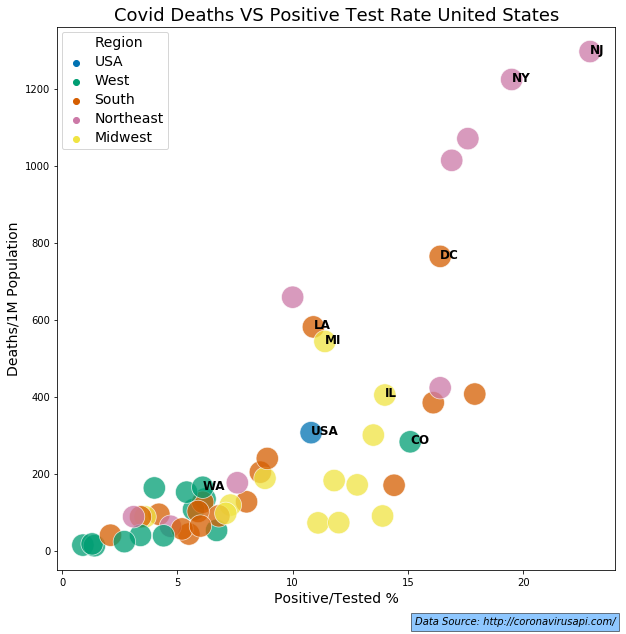

In [48]:

def plot_testing_v_death(all_df,annotate=[],ax=False):
    if ax:
        has_ax = True
    else:
        has_ax=False
    all_df['color'] = all_df['State'].apply(lambda x: 'orangered' if x in annotate else 'dodgerblue')
    all_df['size'] = all_df['Tested'].apply(lambda x: (x/10000))
#     all_df['alpha'] = all_df['State'].apply(lambda x: 1 if x in annotate else .75)
    plt.style.use('seaborn-colorblind')
    if not has_ax:
        fig,ax=plt.subplots(figsize=(10,10))
    else:
        fig = ax.get_figure()
#     ax.scatter(all_df['Positive/Tested %'],y=all_df['Deaths/1M People'],c=all_df['region'],s = all_df['size'],alpha=.75)
    sns.scatterplot(x='Positive/Tested %',y='Deaths/1M People',hue='Region',s=500,data=all_df[all_df['State']!='PR'],ax=ax,alpha=0.75)
    ax.set_title("Covid Deaths VS Positive Test Rate United States",fontsize=18)
    ax.set_xlabel('Positive/Tested %',fontsize=14)
    ax.set_ylabel("Deaths/1M Population",fontsize=14)
    ax.grid(False)
    for state in annotate:
        coords = all_df[all_df['State']==state][['Positive/Tested %','Deaths/1M People']].values[0]

        xycoords = (coords[0],coords[1]-5)
        ax.annotate(state,(coords[0],coords[1]),xytext=xycoords,fontweight='bold',fontsize=12)
    plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend text
    ax.text(1,-.1,'Data Source: http://coronavirusapi.com/',fontsize=10,horizontalalignment='right',fontstyle='italic', bbox=dict(facecolor='dodgerblue',alpha=0.5),transform = ax.transAxes)

    return fig,ax

fig,ax = plot_testing_v_death(all_df,states_to_annotate)


fig.savefig('covid_test_rate.png')

In [ ]:
fig,ax=plt.subplots(15,15)
sns.barplot(x='State',y='Tested',hue='Region',data=all_df[all_df['State']!='PR'],ax=ax)

AttributeError: 'numpy.ndarray' object has no attribute 'bar'

In [ ]:
def plot_testing_vs_size(all_df,annotate=[]):
    
    all_df['color'] = all_df['State'].apply(lambda x: 'orangered' if x in annotate else 'dodgerblue')
    all_df['size'] = all_df['Positive/Tested %'].apply(lambda x: (x*10))

#     all_df['size'] = all_df['State'].apply(lambda x: 80 if x in annotate else 500)
#     all_df['alpha'] = all_df['State'].apply(lambda x: 1 if x in annotate else .75)
    plt.style.use('seaborn-colorblind')
    fig,ax=plt.subplots(figsize=(10,10))
#     ax.scatter(all_df['Positive/Tested %'],y=all_df['Deaths/1M People'],c=all_df['region'],s = all_df['size'],alpha=.75)
    sns.scatterplot(x='Tested/1M People',y='Deaths/1M People',hue='Region',data=all_df[all_df['State']!='PR'],ax=ax,alpha=0.75)
    ax.set_title("Covid Deaths VS Testing Positivity Rate by State",fontsize=18)
    ax.set_xlabel('Tested/1M People',fontsize=14)
    ax.set_ylabel("Deaths/1M Population",fontsize=14)
    ax.grid(False)
    for state in annotate:
        coords = all_df[all_df['State']==state][['Tested','Deaths/1M People']].values[0]

        xycoords = (coords[0],coords[1]-5)
        ax.annotate(state,(coords[0],coords[1]),xytext=xycoords,fontweight='bold',fontsize=12)
    plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend text
    ax.text(1,-.1,'Data Source: http://coronavirusapi.com/',fontsize=10,horizontalalignment='right',fontstyle='italic', bbox=dict(facecolor='dodgerblue',alpha=0.5),transform = ax.transAxes)

    return fig,ax
plot_testing_vs_size(all_df,states_to_annotate)

In [ ]:
all_df.sort_values(by='size',ascending=False)

In [ ]:
all_df.head()

In [ ]:
all_df.head()

In [ ]:
county_data.head()

In [ ]:
import geopandas as gpd

geo_df = gpd.read_file('./shape_files/cb_2018_us_county_500k.shp')

In [ ]:
geo_df['fips'] = geo_df['GEOID'].astype(float)

In [ ]:
final_geo_df = county_data.merge(geo_df,how='left',on='fips')

In [ ]:
final_geo_df.head()

In [ ]:
final_geo_df = final_geo_df[~final_geo_df['state'].isin(['Hawaii','Alaska','Puerto Rico'])].reset_index(drop=True)

In [ ]:
day_list = final_geo_df['date'].unique().tolist()[11:]


In [ ]:
import mapclassify
import numpy as np

scheme = mapclassify.NaturalBreaks(final_geo_df['cases'],k=5)


In [ ]:
final_geo_df.dropna(inplace=True)


In [ ]:
import geoplot
import geoplot.crs as gcrs
from celluloid import Camera
from IPython.display import HTML
# contiguous_usa = gpd.read_file(geoplot.datasets.get_path('contiguous_usa'))
# ax3 = geoplot.webmap(contiguous_usa,projection=gcrs.WebMercator(),figsize=(15,10))
# fig3 = ax3.get_figure()
# camera = Camera(fig3)
# for day in day_list[::5]:
#     print(day)
#     geoplot.webmap(contiguous_usa,projection=gcrs.WebMercator(),ax=ax3)

#     test_geo = gpd.GeoDataFrame(final_geo_df[final_geo_df['date']==day])
#     geoplot.choropleth(
#     test_geo, hue='cases', 
#     cmap='Reds', ax = ax3, edgecolor=None,scheme = scheme,legend=True, legend_kwargs={'bbox_to_anchor':(.9,.2)}
#  )
#     ax3.text(0.5,1,'Total Covid Cases by Country: {}'.format(day),fontsize=20,horizontalalignment='center',transform = ax3.transAxes)
# #     ax3.axis('off')
    
#     camera.snap()
# animation = camera.animate(interval=500)
# HTML(animation.to_html5_video())


In [ ]:
# NY = results_df[results_df['state']=='New York City'].reset_index(drop=True)
# NY.head()

In [ ]:
# NY['start_week'].dt.strftime('%Y-%m-%d')

In [ ]:
# fig,ax = plt.subplots(figsize=(10,10))
# camera = Camera(fig)
# for i in range(NY.shape[0]):
#     NY.iloc[0:i+1]['total_deaths'].plot(ax=ax,color='dodgerblue')
#     ax.set_xticklabels(NY['start_week'].dt.strftime('%Y-%m-%d').iloc[::2])
#     ax.text(0.5,1.05,'Death Count in NYC: Week of {}: {:.0f}'.format(NY['start_week'].dt.strftime('%Y-%m-%d').iloc[i],NY['total_deaths'].iloc[i]),fontsize=20,horizontalalignment='center',transform = ax.transAxes)
#     ax.set_ylabel('Death Count',fontsize=14)
#     ax.set_xlabel("Week of",fontsize=14)
#     ax.text(1,-.1,'Data Source: https://data.cdc.gov/NCHS/Provisional-COVID-19-Death-Counts-by-Week-Ending-D/r8kw-7aab',fontsize=10,horizontalalignment='right',fontstyle='italic', bbox=dict(facecolor='dodgerblue',alpha=0.5),transform = ax.transAxes)
#     camera.snap()
    
# animation = camera.animate(interval=500)
# animation.save('weekly_deaths_nyc.mp4')

# HTML(animation.to_html5_video())
